# Временные ряды - Таксопарк N

## Загрузка и ресемплирование

In [1]:
#установим LightGBM
!pip install lightgbm

In [2]:
#импортируем необходимые библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

#необходимые ML-библиотеки
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
#подбор гиперпараметров
from sklearn.experimental import enable_halving_search_cv
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit, HalvingGridSearchCV, RandomizedSearchCV
from statsmodels.tsa.seasonal import seasonal_decompose


In [3]:
try:
    df = pd.read_csv('D:/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [4]:
df.head(7)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


* У нас в наличии более 26 тыс. записей, хотя число изменится после требуемого далее ресемплинга

* Уже сейчас мы видим, что есть дни без заказов, а в некоторые дни их больше сотни. 

* В среднем их от одного до двух десятков 

**Перейдем к анализу данных по заказам**

## Анализ временных рядов

In [7]:
#изучим границы временных рядов
df.index.min(), df.index.max()

(Timestamp('2018-03-01 00:00:00'), Timestamp('2018-08-31 23:50:00'))

In [8]:
#выясним, не нарушен ли порядок временных рядов
df.index.is_monotonic_increasing

True

**Как мы видим, в наборе содержится пласт данных с 1 марта 2018 по 31 августа того же года, а порядок рядов не нарушен.**

In [9]:
df.resample('24H').sum().head(7)

,num_orders
datetime,
2018-03-01,1364
2018-03-02,1506
2018-03-03,1290
2018-03-04,1141
2018-03-05,1259
2018-03-06,1109
2018-03-07,1441


In [10]:
df.resample('24H').mean().head(7)

,num_orders
datetime,
2018-03-01,9.472222
2018-03-02,10.458333
2018-03-03,8.958333
2018-03-04,7.923611
2018-03-05,8.743056
2018-03-06,7.701389
2018-03-07,10.006944


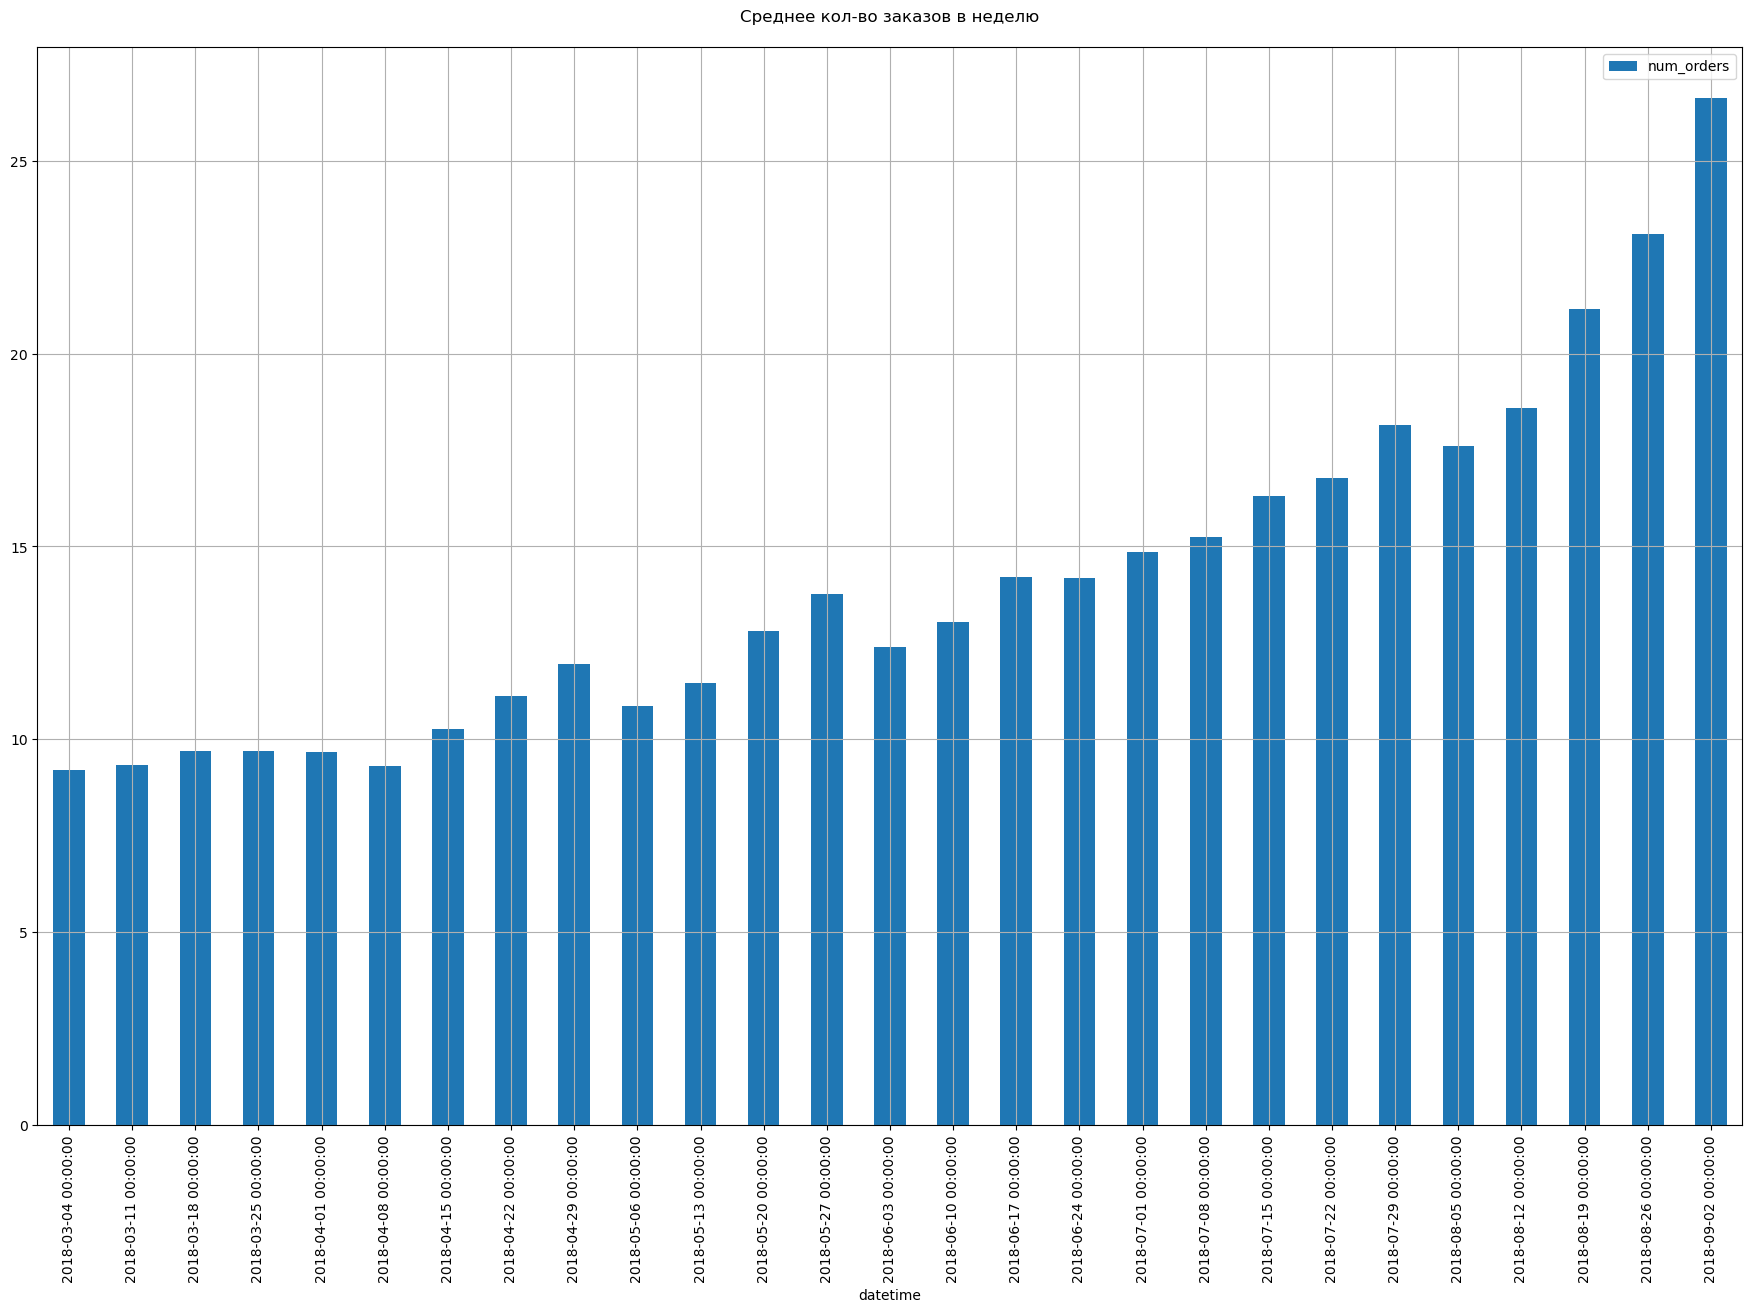

In [11]:
df.resample('1W').mean().plot(kind='bar', figsize=(22, 14),
                              grid=True, title='Среднее кол-во заказов в неделю\n');

**Как видно по графикам с недельной и суточной разбивкой, везде наблюдается растущий тренд от месяца к месяцу**

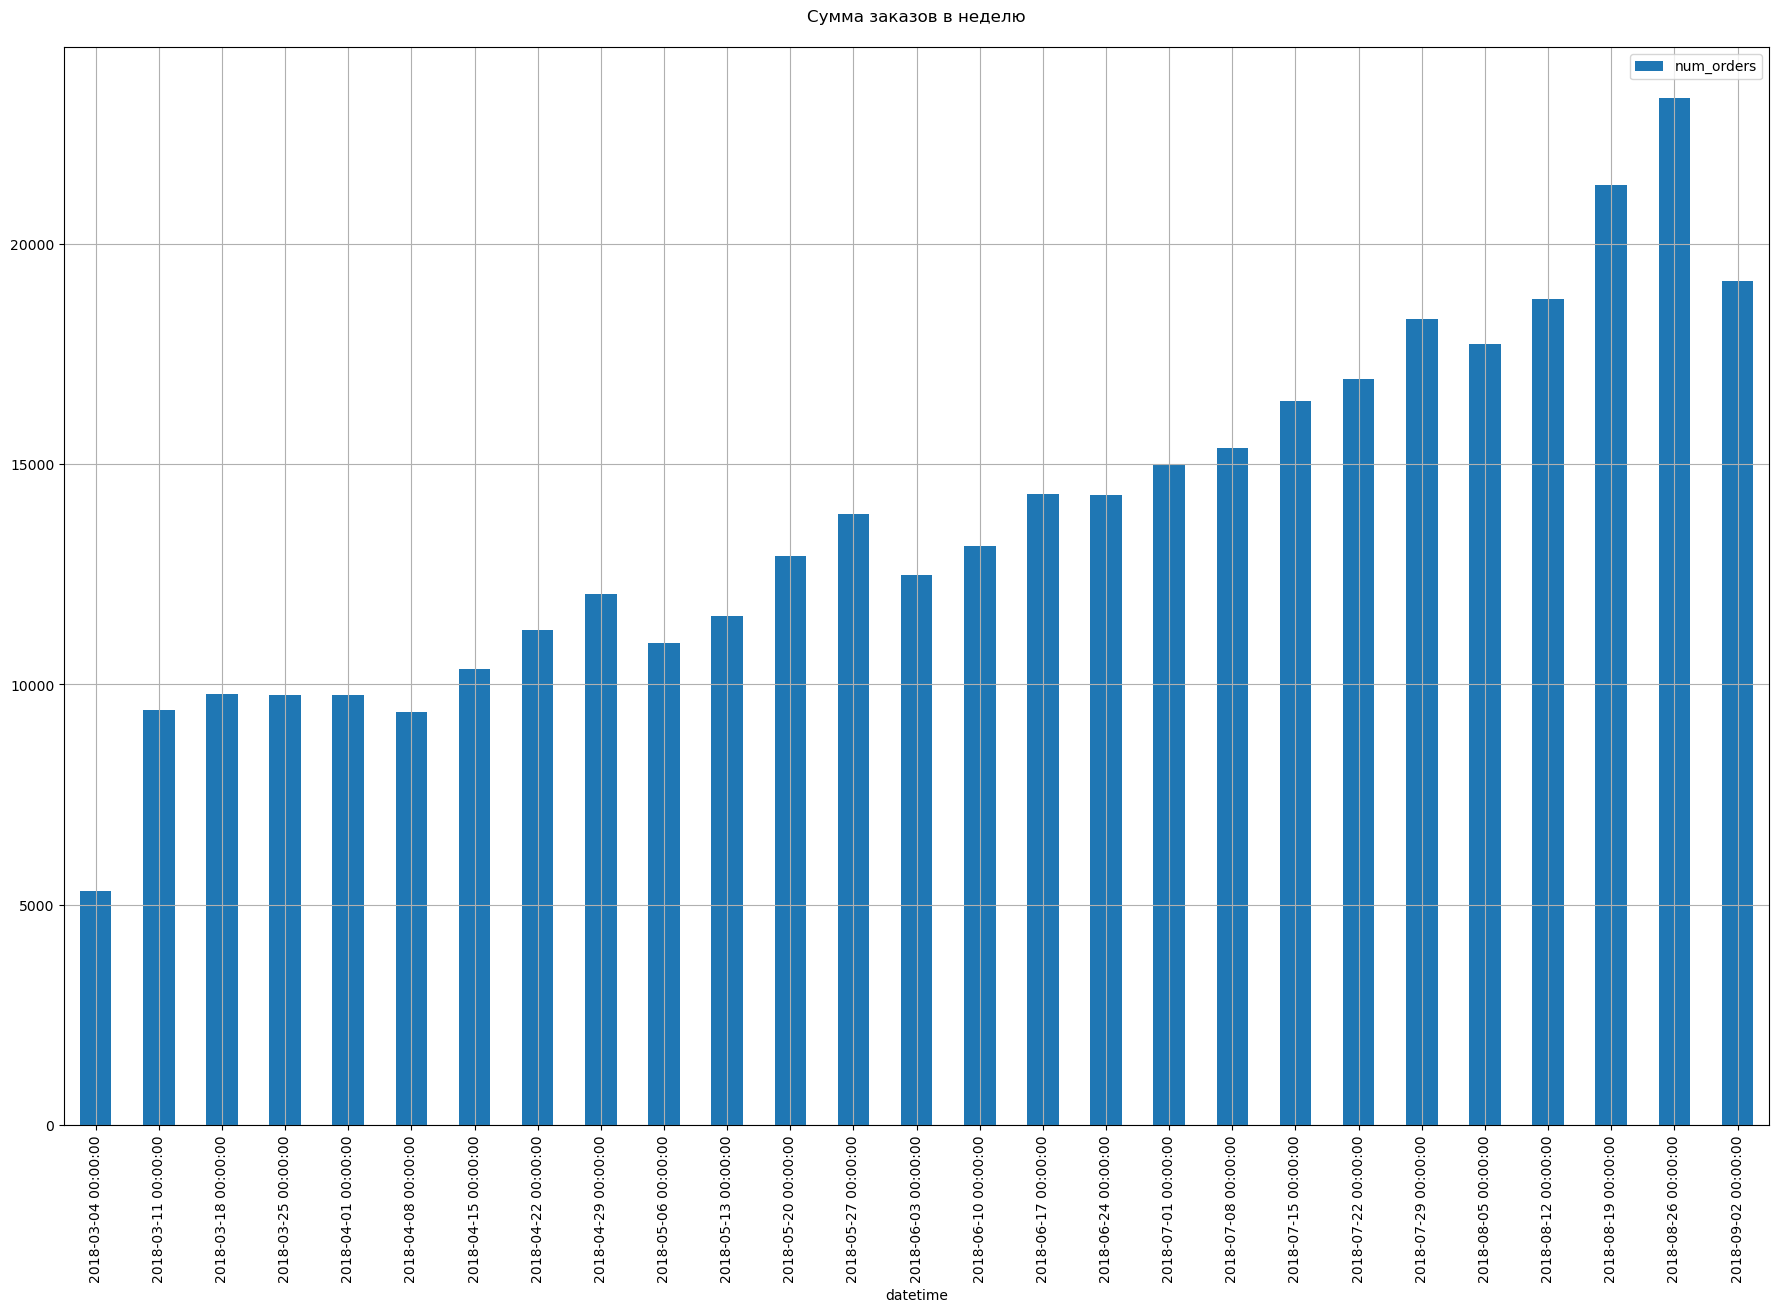

In [12]:
df.resample('1W').sum().plot(kind='bar', figsize=(22, 14),
                              grid=True, title='Cумма заказов в неделю\n');

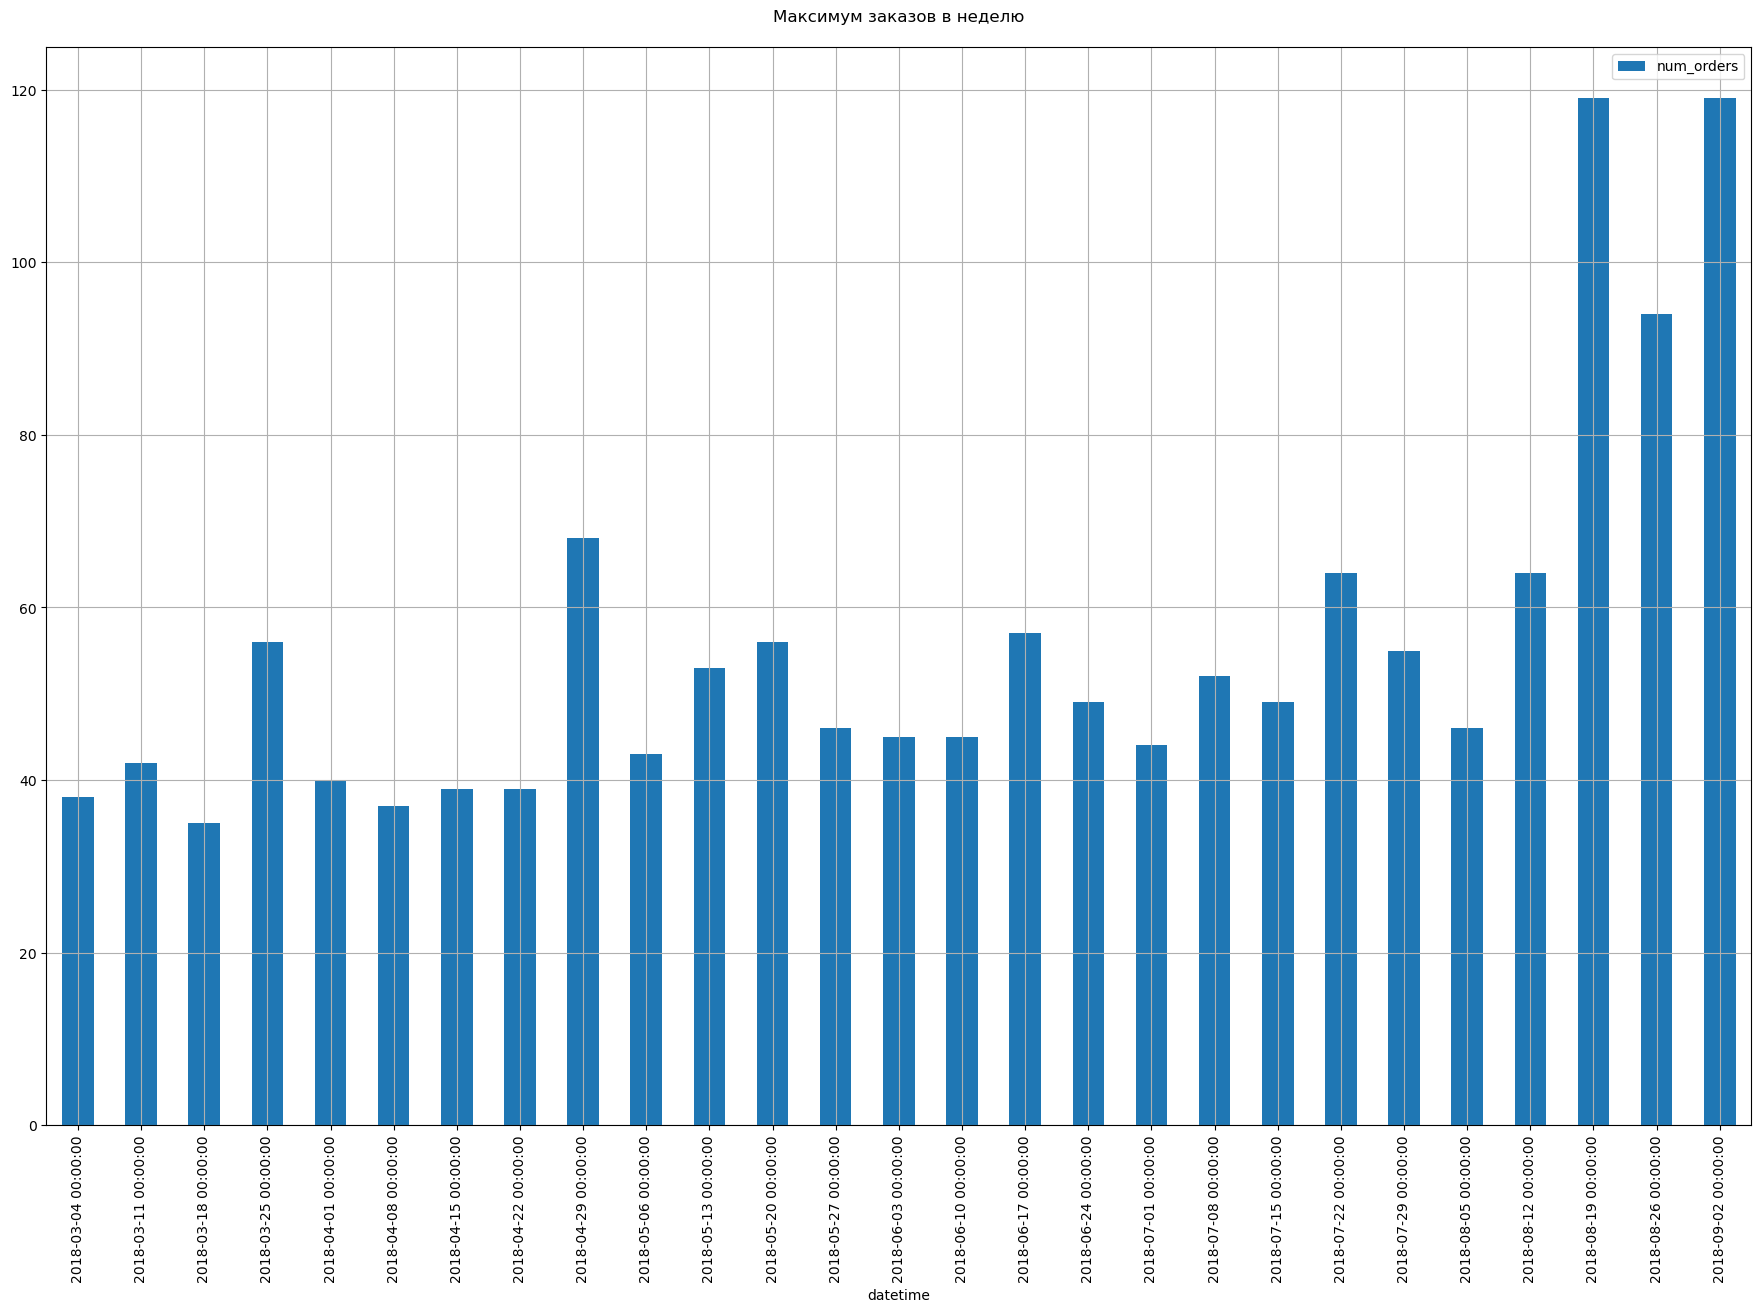

In [13]:
df.resample('1W').max().plot(kind='bar', figsize=(22, 14),
                              grid=True, title='Максимум заказов в неделю\n');

                     Увеличим окно до одного месяца и взглянем на среднее, сумму и максимум заказов

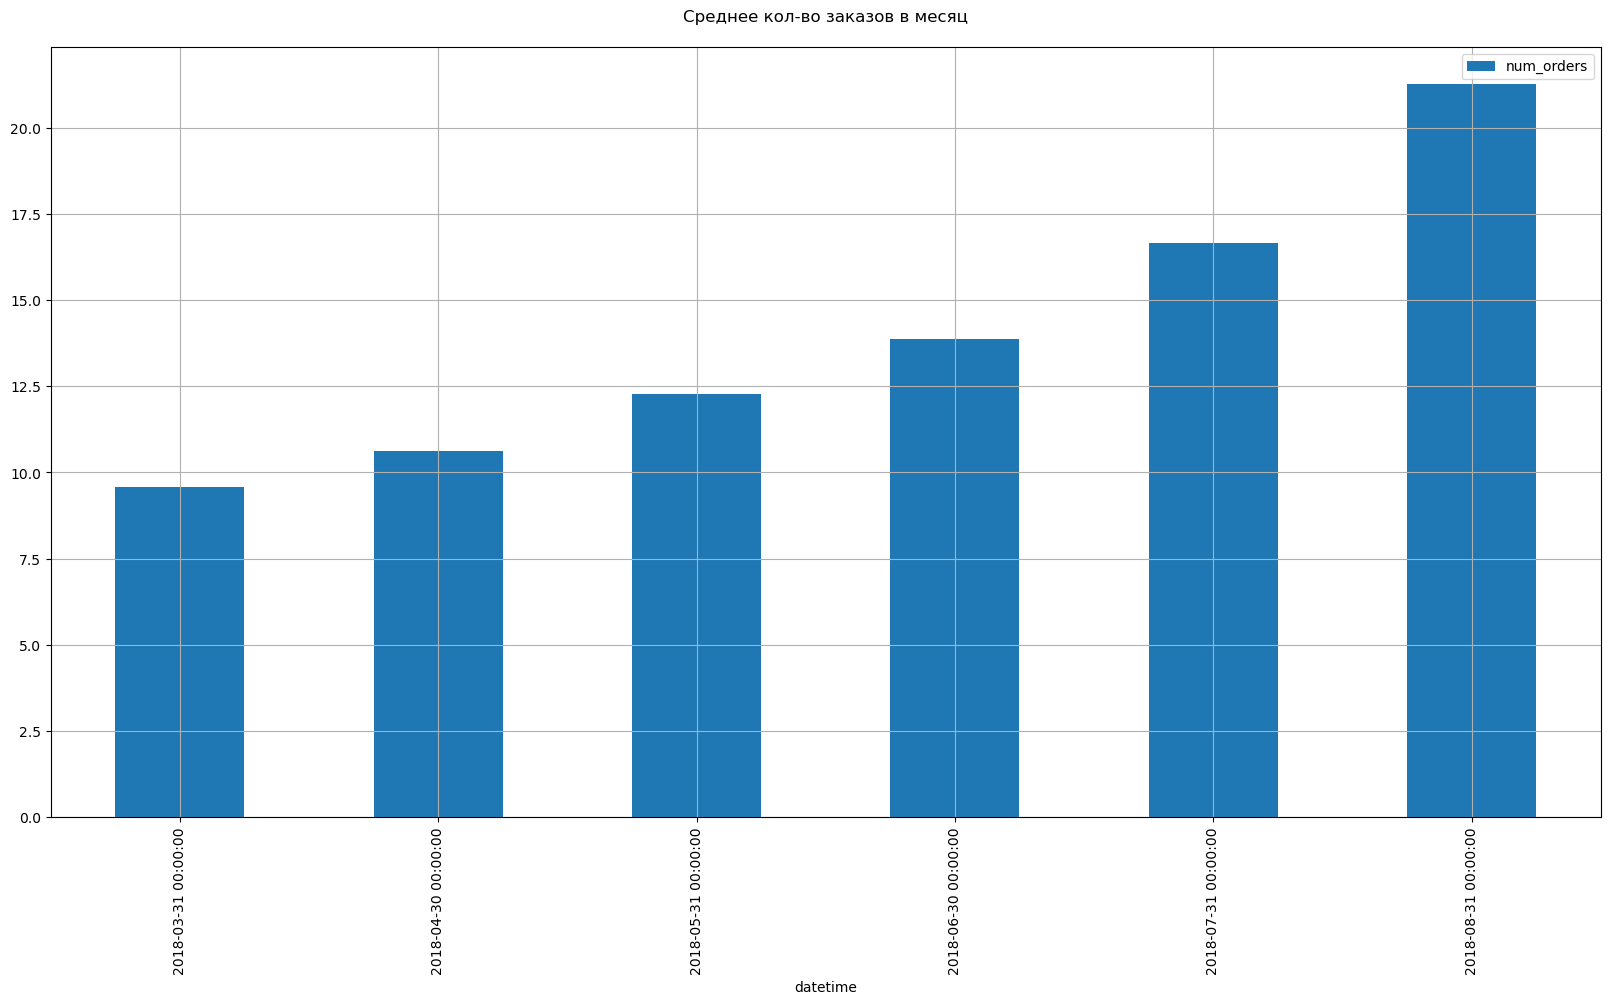

In [14]:
df.resample('1M').mean().plot(kind='bar', figsize=(20, 10),
                              grid=True, title='Среднее кол-во заказов в месяц\n');

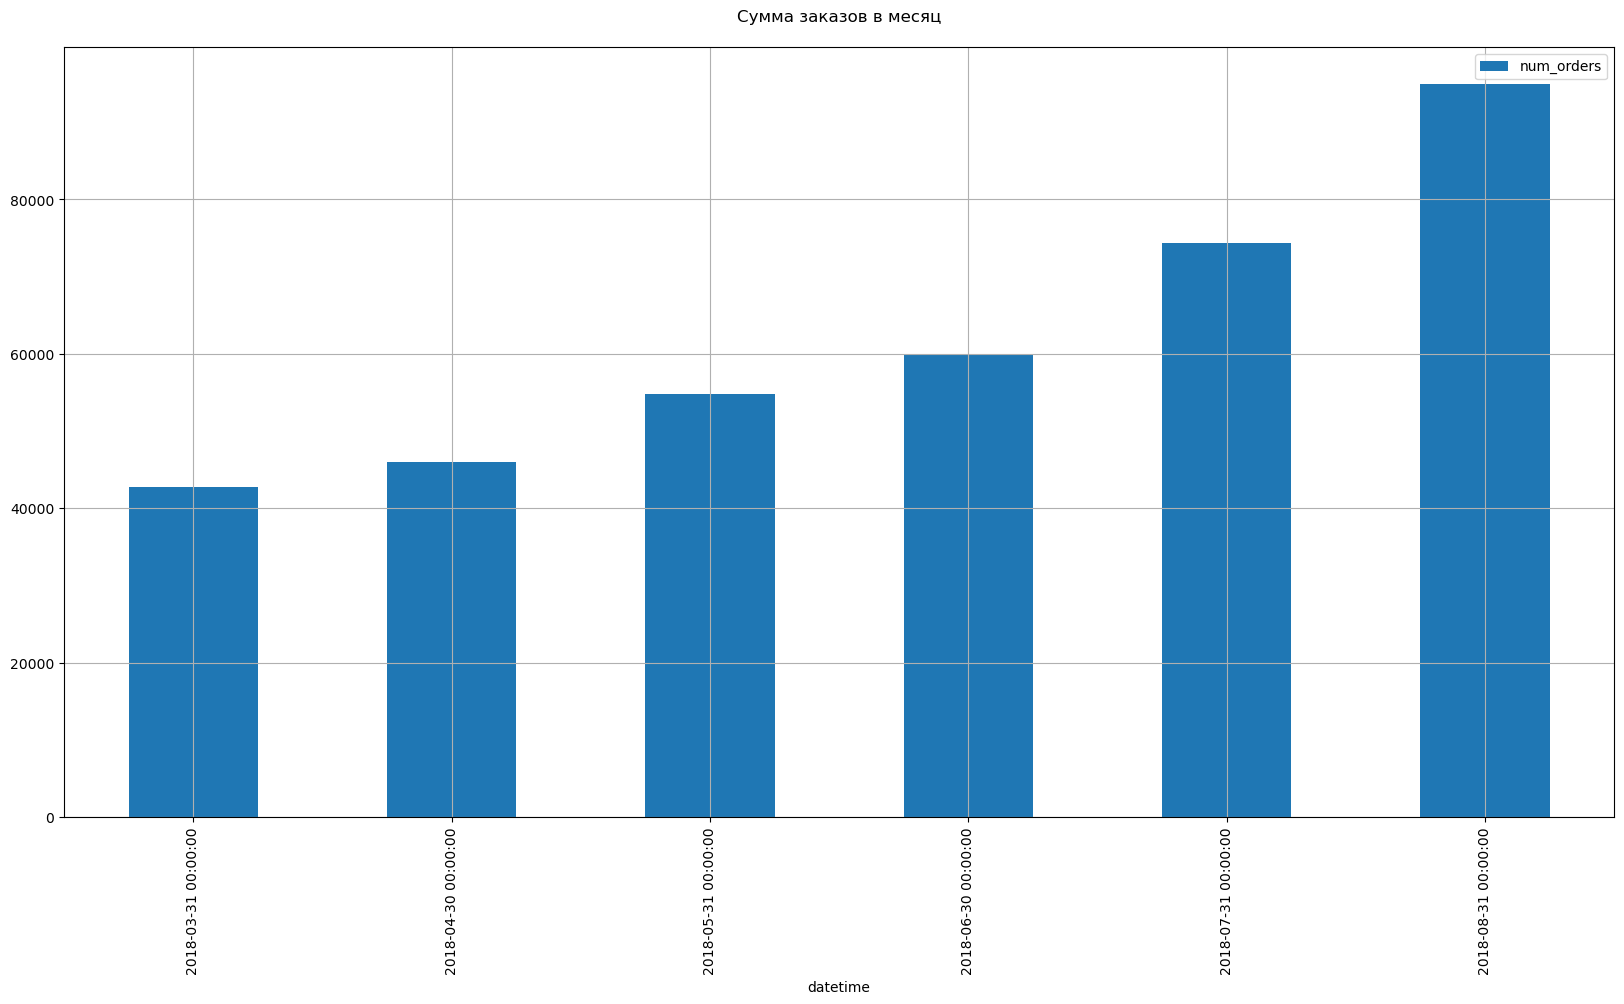

In [15]:
df.resample('1M').sum().plot(kind='bar', figsize=(20, 10),
                              grid=True, title='Cумма заказов в месяц\n');

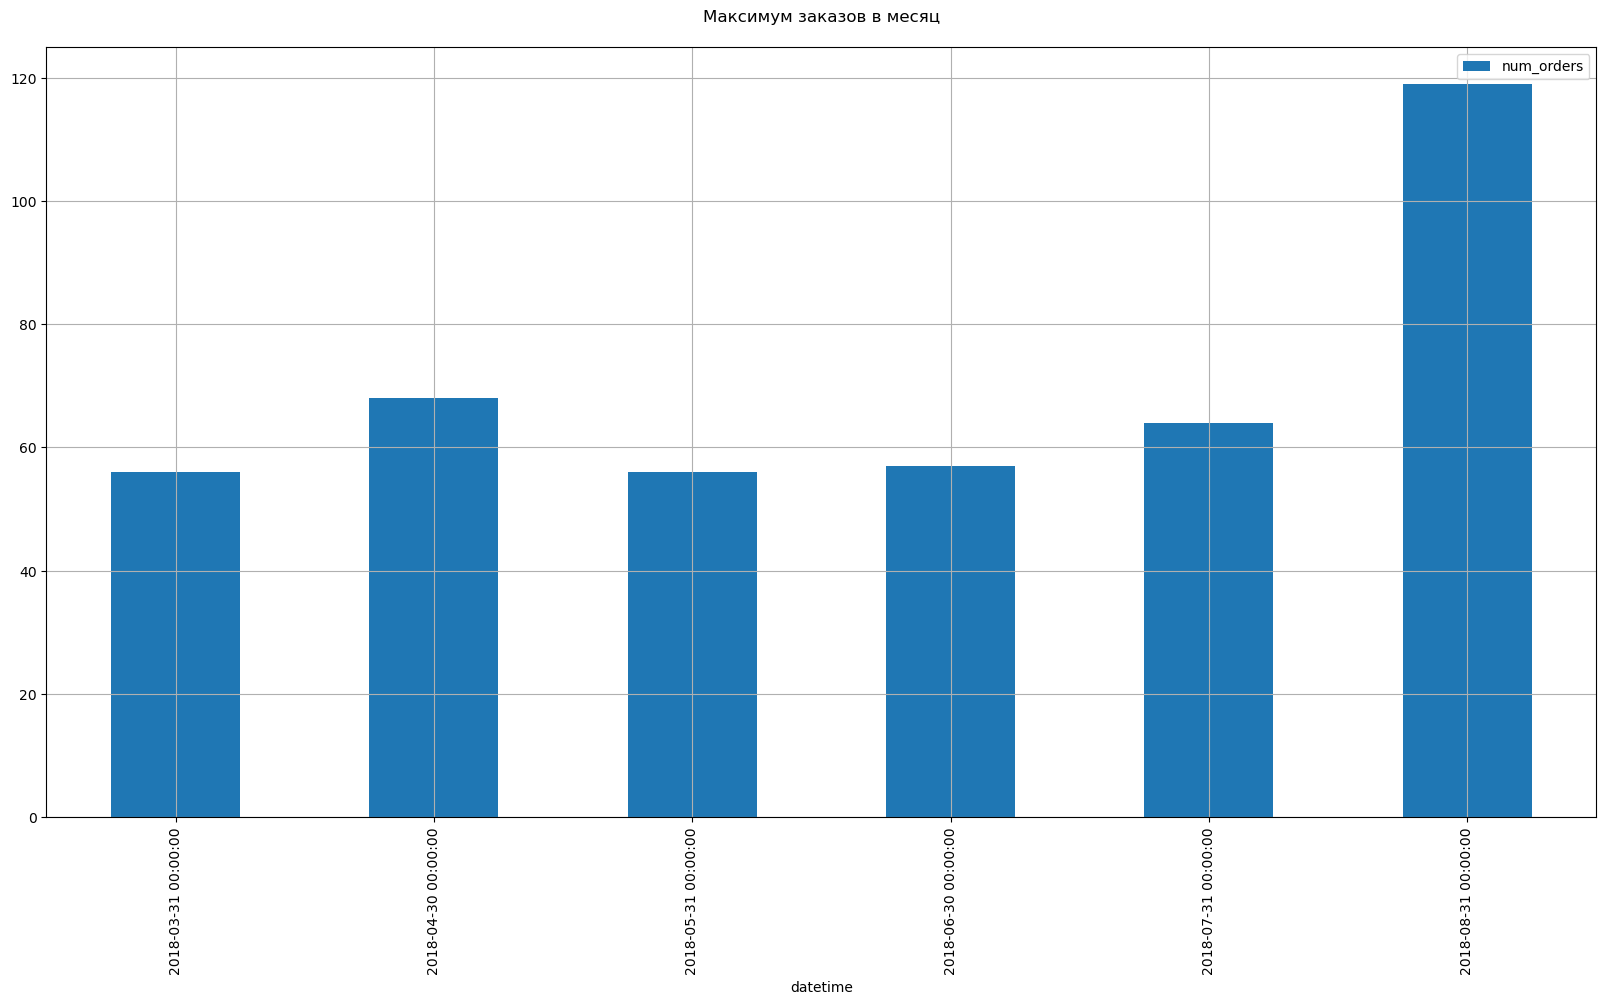

In [16]:
df.resample('1M').max().plot(kind='bar', figsize=(20, 10),
                              grid=True, title='Максимум заказов в месяц\n');

### Выводы по графическому анализу

* **Мы наблюдаем растущий тренд от месяца к месяцу, от неделе к неделе**
* Помимо последней и третьей с конца ряда недели, максимумами на недельном графике выделяется последняя неделя марта и последняя неделя апреля. 
* Максимум заказов наблюдается в августе, но несмотря на восходящий тренд от начала ряда к концу, выделяется апрель
* Среднее кол-во заказов также демонстрирует восходящий тренд без особых локальных пиков

**Теперь необходимо проверить пропуски в данных**

In [17]:
#напишем функцию для краткого обзора набора данных
def eda_analyse(df):
    '''
    Функция eda_analyse принимает на вход 
    датафрейм и возвращает краткую сводку
    о кол-ве столбцов, строк, сумме явных 
    дубликатов, среднем кол-во пропусков в столбцах,
    а также расходе памяти каждым столбцом
    '''
    print(f'Датасет содержит {df.shape[0]} cтроки(-у) и {df.shape[1]} столбцов.\n')
    print(f'В наборе данных имеется {df.duplicated().sum()} явных дубликатов.\n')
    print('Среднее количество пропусков в столбцах равно:\n', df.isna().mean())
    print('Каждый столбец датафрейма расходует памяти:\n', df.memory_usage(deep=True))

In [18]:
#выведем информацию
eda_analyse(df)

Датасет содержит 26496 cтроки(-у) и 1 столбцов.

В наборе данных имеется 26415 явных дубликатов.

Среднее количество пропусков в столбцах равно:
 num_orders    0.0
dtype: float64
Каждый столбец датафрейма расходует памяти:
 Index         211968
num_orders    211968
dtype: int64


**Проверим, что docstring для описания функционала функции сохранился, если кто-то из коллег в дальнейшем захочет уточнить его.**

In [19]:
eda_analyse?

Signature: eda_analyse(df)
Docstring:
Функция eda_analyse принимает на вход 
датафрейм и возвращает краткую сводку
о кол-ве столбцов, строк, сумме явных 
дубликатов, среднем кол-во пропусков в столбцах,
а также расходе памяти каждым столбцом
File:      c:\users\john\appdata\local\temp\ipykernel_10544\1120882777.py
Type:      function

In [20]:
df = df.resample('1H').sum()
df

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


In [21]:
#изучим наиболее выдающиеся значения
df.sort_values(by='num_orders', ascending=False).head(7)

,num_orders
datetime,
2018-08-20 02:00:00,462
2018-08-13 02:00:00,437
2018-08-27 02:00:00,408
2018-08-30 17:00:00,342
2018-08-27 04:00:00,295
2018-08-18 00:00:00,281
2018-08-26 00:00:00,281


In [22]:
#изучим наименее выдающиеся значения
df.sort_values(by='num_orders', ascending=False).tail(7)

,num_orders
datetime,
2018-04-12 06:00:00,2
2018-03-30 06:00:00,2
2018-05-17 06:00:00,2
2018-03-09 05:00:00,1
2018-04-03 06:00:00,1
2018-04-05 06:00:00,1
2018-04-06 06:00:00,0


### Выделение компонент (тренд/сезонность/остаток)

In [23]:
decomp = seasonal_decompose(df)

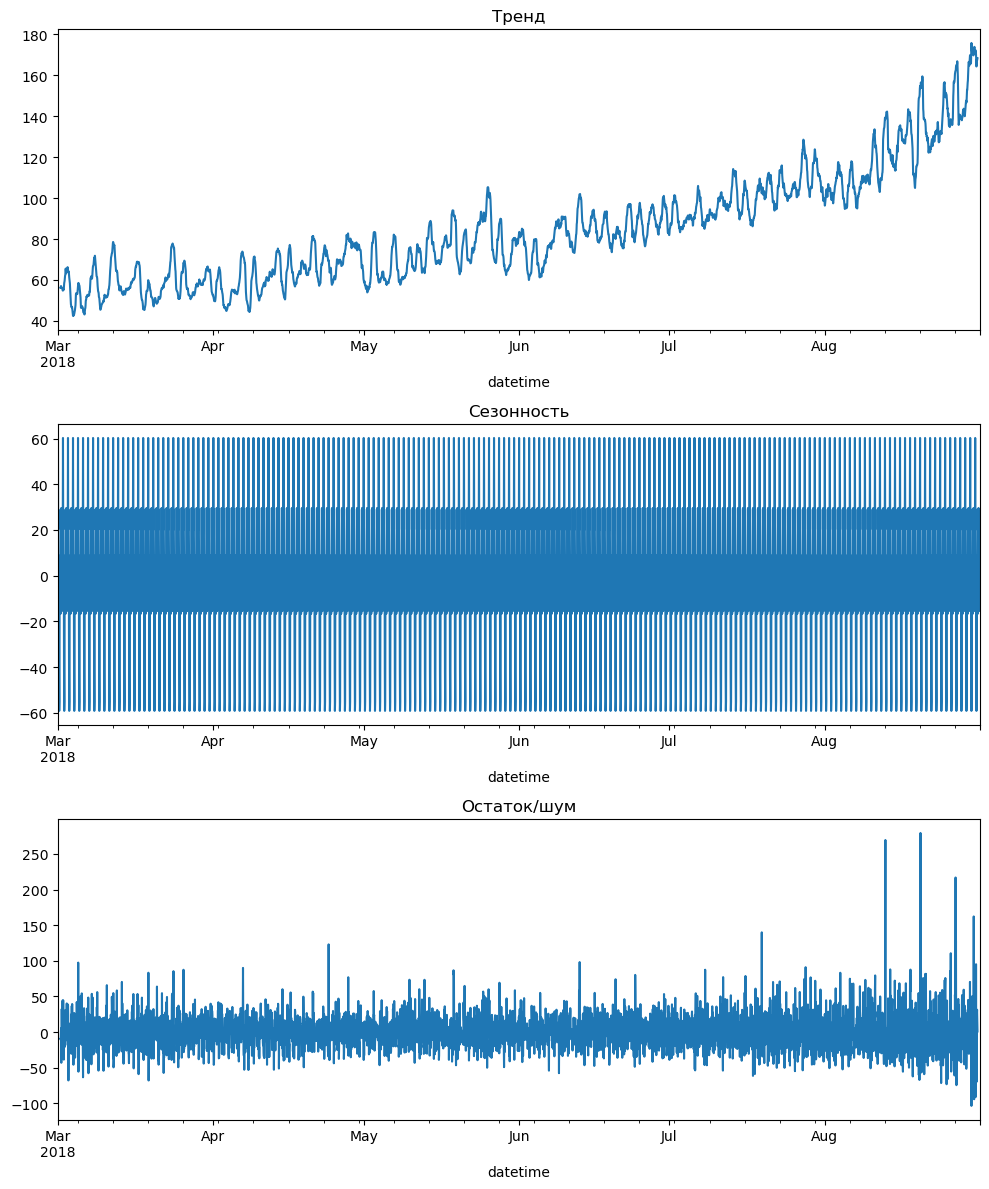

In [24]:
plt.figure(figsize=(10, 12))
plt.subplot(311)
#доп.атрибут для корректного отображения
decomp.trend.plot(ax=plt.gca())
plt.title('Тренд')
plt.subplot(312)
decomp.seasonal.plot(ax=plt.gca())
plt.title('Сезонность')
plt.subplot(313)
decomp.resid.plot(ax=plt.gca()) 
plt.title('Остаток/шум')
plt.tight_layout()

* Мы можем наблюдать, что шум довольно разнообразный, есть несколько пиков ближе к концу ряда, что примерно совпадает с максимумами по заказам в конце августа
* Сезонности не наблюдается, ряд стационарный без изменения амплитуды или среднего
* Тренд неровный, восходящий с несколькими переломами в виде локальных максимумов

### Добавление признаков

*Добавим дополнительные признаки с учетом горизонта прогнозирования. Поскольку мы стремимся предсказать тренд на горизонте часа, то мы добавим день недели (будние/выходные могут сильно влиять на спрос такси в аэропорт), собственно час и скользящее среднее за сутки, которое тоже может отражать тренд.*

In [25]:
#напишем функцию для создания столбцов с днями, месяцем, неделей
def make_features(df, max_lag, rolling_mean_size):
    df['dayofweek'] = df.index.dayofweek
    df['hour'] = df.index.hour
    
    #цикл для "отстающих значений"
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()


make_features(df, 2, 24)

In [26]:
#проверка новых столбцов
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   num_orders    4416 non-null   int64  
 1   dayofweek     4416 non-null   int32  
 2   hour          4416 non-null   int32  
 3   lag_1         4415 non-null   float64
 4   lag_2         4414 non-null   float64
 5   rolling_mean  4392 non-null   float64
dtypes: float64(3), int32(2), int64(1)
memory usage: 207.0 KB


In [27]:
df.sample(7, random_state=42)

,num_orders,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-05-07 15:00:00,62,0,15,79.0,52.0,81.500000
2018-04-30 11:00:00,63,0,11,120.0,91.0,77.666667
2018-08-13 16:00:00,144,0,16,175.0,102.0,139.541667
2018-05-11 23:00:00,119,4,23,95.0,94.0,68.708333
2018-03-07 00:00:00,100,2,0,47.0,81.0,46.208333
2018-05-13 08:00:00,84,6,8,13.0,23.0,64.875000
2018-07-23 14:00:00,86,0,14,93.0,118.0,113.708333


In [28]:
df = df.dropna()

## Разбивка на выборки

In [29]:
#выделим обучающие признаки и целевой
X = df.drop(['num_orders'], axis=1)
y = df['num_orders']

In [30]:
X.head()

,dayofweek,hour,lag_1,lag_2,rolling_mean
datetime,,,,,
2018-03-02 00:00:00,4,0,58.0,113.0,56.833333
2018-03-02 01:00:00,4,1,90.0,58.0,55.416667
2018-03-02 02:00:00,4,2,120.0,90.0,56.875000
2018-03-02 03:00:00,4,3,75.0,120.0,57.041667
2018-03-02 04:00:00,4,4,64.0,75.0,56.958333


In [31]:
y.head()

datetime
2018-03-02 00:00:00     90
2018-03-02 01:00:00    120
2018-03-02 02:00:00     75
2018-03-02 03:00:00     64
2018-03-02 04:00:00     20
Freq: H, Name: num_orders, dtype: int64

In [32]:
X.shape, y.shape

((4392, 5), (4392,))

**Учитывая размер датасета, если разбивать его на много частей, то мы рискуем плохо обучить модели, поэтому вы выделим обучающую выборку в 90% и тестовую в 10% от общего объема данных, как это требуется. Валидационной выборкой мы можем принебречь, поскольку ниже мы будем использовать такие инструменты, как HalvingGridSearchCV, которые проводят кросс-валидацию при подборе параметров. Что до инструмента, то мы используем HalvingGridSearchCV, т.к. он работает в 8-20 раз быстрее стандартного GridSearchCV, но его метрика качества обычно уступает не более, чем на 1-1,5%**

In [33]:
#разделение на выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.9, shuffle=False, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3952, 5), (440, 5), (3952,), (440,))

**Разделение прошло успешно, можно переходить к обучению моделей**

## Обучение моделей

*Начнем с простой модели случайного леса для задания бейзлайна, а затем попробуем увеличить сложность моделей*

***Зададим кол-во n_splits так, чтобы размер валидационной выборки при проведении кросс-валидации примерно совпадал с размером тестовой выборки. Размер тестовой выборки у нас 10%, похожео, что n_splits=8, .т.е 1/9x90%=10% - будет точыме попаданиме***.

### Случайный лес

In [34]:
#инициализируем первую регрессионную модель
rf_model = RandomForestRegressor(random_state=42)

#сетка для основных гиперпараметров
rf_grid =  {
    'n_estimators' : np.arange(2, 50, 2),
    'max_depth': np.arange(2,8),
    'min_samples_leaf': np.arange(2,7)
}

#передадим модель  и гиперпараметры методу HalvingGridSearch
rf_model_grid = HalvingGridSearchCV(rf_model, rf_grid, scoring='neg_root_mean_squared_error',
                                    cv=TimeSeriesSplit(n_splits=8), n_jobs=-1, random_state=42)

In [35]:
#обучим модель случайного леса и сохраним наилучшие параметры
best_model_rf = rf_model_grid.fit(X_train, y_train).best_estimator_

print('Лучшие параметры:', rf_model_grid.best_params_)
print('Лучшая оценка:', rf_model_grid.best_score_)

Лучшие параметры: {'max_depth': 7, 'min_samples_leaf': 3, 'n_estimators': 46}
Лучшая оценка: -25.724435732708237


In [36]:
print(f'Метрика на кросс-валидации составила {rf_model_grid.best_score_}(RMSE)')

Метрика на кросс-валидации составила -25.724435732708237(RMSE)


In [37]:
#сохраним результат в отдельную таблицу
columns = ['model', 'RMSE']
df_results = pd.DataFrame()
rf_results = ['Random Forest', rf_model_grid.best_score_]
#создадим датафрейм
rf_df = pd.DataFrame([rf_results], columns=columns)
df_results = pd.concat([df_results, pd.DataFrame(rf_df, columns=columns)]).reset_index(drop=True)

df_results

,model,RMSE
0,Random Forest,-25.724436


**Первая же модель показывает результат более, чем в два раза ниже метрики, требуемой в проекте. Мы продолжаем эксперимент и надеемся, что метрика будет такой же низкой на тестовой выборке**

### Линейная регрессия

In [38]:
#инициализация модели
regr_model = LinearRegression()

param_grid = {'n_jobs': [-1]}

#передадим модель  и гиперпараметры методу HalvingGridSearch
regr_model_grid = HalvingGridSearchCV(regr_model, param_grid, scoring='neg_root_mean_squared_error',
                                      cv=TimeSeriesSplit(n_splits=3))

In [39]:
#найдем наилучшую модель линейной регрессии
best_model_regr = regr_model_grid.fit(X_train, y_train).best_estimator_

print('Лучшие параметры:', regr_model_grid.best_params_)
print('Лучшая оценка:', regr_model_grid.best_score_)

Лучшие параметры: {'n_jobs': -1}
Лучшая оценка: -32.79604817654159


In [40]:
print(f'Метрика на кросс-валидации составила {regr_model_grid.best_score_}(RMSE)')

Метрика на кросс-валидации составила -32.79604817654159(RMSE)


In [41]:
#сохраним результат в отдельную таблицу
regr_results = ['Linear Regression', regr_model_grid.best_score_]
#создадим датафрейм
regr_df = pd.DataFrame([regr_results], columns=columns)
df_results = pd.concat([df_results, pd.DataFrame(regr_df, columns=columns)]).reset_index(drop=True)

df_results

,model,RMSE
0,Random Forest,-25.724436
1,Linear Regression,-32.796048


**Здесь метрика RMSE уже на 10 пунктов выше. Продолжаем проверку моделей**

### LightGBM

In [42]:
lgb_model = lgb.LGBMRegressor(task='train', metric='rmse',
                               random_state=42, force_col_wise=True)

rs_params = {
        'bagging_fraction': (0.5, 0.8),
        'feature_fraction': (0.5, 0.8),
        'max_depth': (7, 16),
        'min_data_in_leaf': (90, 120),
        'num_leaves': (100, 1550)
}

#Инициализируем RandomizedGridSearch c гиперпараметрами LightGBM
rs_cv = RandomizedSearchCV(estimator=lgb_model, param_distributions=rs_params,
                           cv=TimeSeriesSplit(n_splits=8), n_iter=100, verbose=1)

In [43]:
best_lgb = rs_cv.fit(X_train, y_train)

Fitting 8 folds for each of 32 candidates, totalling 256 fits
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5
[LightGBM] [Info] Total Bins 354
[LightGBM] [Info] Number of data points in the train set: 440, number of used features: 5
[LightGBM] [Info] Start training from score 56.336364
[LightGBM] [Warning] No further spl

D:\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:305: UserWarning: The total space of parameters 32 is smaller than n_iter=100. Running 32 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(



[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [44]:
#сохраним результат в отдельную таблицу
lgb_results = ['LightGBM', mean_squared_error(y_train, best_lgb.predict(X_train), squared=False)]
#создадим датафрейм
lgb_df = pd.DataFrame([lgb_results], columns=columns)
df_results = pd.concat([df_results, pd.DataFrame(lgb_df, columns=columns)]).reset_index(drop=True)

df_results

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


,model,RMSE
0,Random Forest,-25.724436
1,Linear Regression,-32.796048
2,LightGBM,18.937366


**Здесь мы получаем еще более точные предсказания. Теперь необходимо проверить модель на тестовой выборке**

## Тестирование лучшей модели

In [45]:
#проверим наилучшую модель на тестовой выборке
ypred_test = rs_cv.predict(X_test)

result_lgb_best = mean_squared_error(y_test, ypred_test, squared=False)
result_lgb_best

[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.5, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5


46.15277407761774

**Мы получили не такие радужные результаты, но они всё еще удовлетворяют требованию заказчика по RMSE(<48). Разница в результатах по метрике выросла на тестовой выборке почти в 3 раза(!), что свидетельствует о переобучении модели. Следует обратить на это внимание при дальнейшей оптимизации**

## Выводы

*Мы исследовали данные за 6 месяцев и проанализировали тренды в них*

* Мы обратили внимание, что имеет место рост количество заказов. В последнюю и третью с конца неделю августа наблюдаются локальные максимумы по количеству заказов, а также максимумы за неделю  
* Также мы не могли не обратить внимание на максимумы по заказам на последней неделе марта и апреля соответственно
* **Что касается подготовки моделей, то наилучшей стал ансамбль решающих деревьев LightGBM, сразу после него идет ансамбль из обычных решающих деревьев(случайный лес), самой слабой оказалась линейная регрессия с 18, -25 и -32 пунктами RMSE соответственно**
* Но, к сожалению, хоть LightGBM и показала достаточную метрику на тестовой выборке, она увеличилась почти в 3 раза на тестовой. 
* Возможно, имеет смысл увеличить тестовую выборку

## Дальнейшие шаги по оптимизации моделей

* Кажется целесообразным увеличении как тестовой, так и обучающей выборки, хотя бы до полного года, чтобы охватить все возможные сезонные закономерности.
* Также необходимо расширить сетку гиперпараметров наилучшей модели и провести полный перебор вариантов по сетке с кросс-валидацией(GridSearchCV)
* Возможно, экспериментирование со скользящими средними и дальнейшее создание новых признаков(feature engineering) на основе существующих также повысит точность регрессионных моделей.

## Иллюстрация предсказаний

In [46]:
#проверка значений и трансформация
ypred_test = ypred_test
ypred_test[:8]

array([145.16960246, 131.08125235, 115.81021693,  95.13438789,
        97.92527424, 113.37344906, 119.54594798, 113.33023203])

In [47]:
#проверка значений
y_test.head(4)

datetime
2018-08-13 16:00:00    144
2018-08-13 17:00:00    152
2018-08-13 18:00:00    104
2018-08-13 19:00:00     91
Freq: H, Name: num_orders, dtype: int64

Изобразим предсказания на графике.

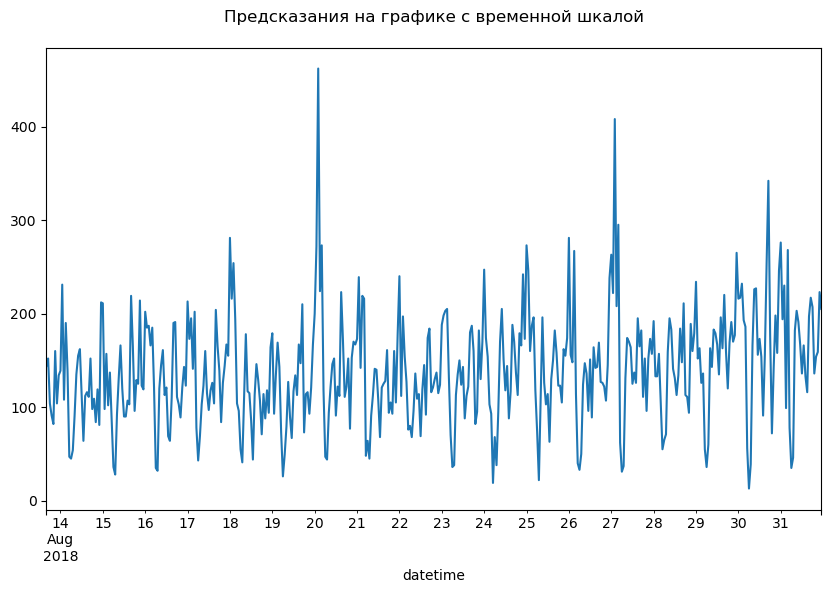

In [48]:
y_test.plot(figsize=(10,6), title='Предсказания на графике с временной шкалой\n');

In [49]:
#добавим результат предсказаний и фактические показания из тестовой выборки в ДФ
forecast_df = pd.DataFrame({'prediction': ypred_test,
                            'fact': y_test
                           }, index=y_test.index)

forecast_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 440 entries, 2018-08-13 16:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  440 non-null    float64
 1   fact        440 non-null    int64  
dtypes: float64(1), int64(1)
memory usage: 10.3 KB


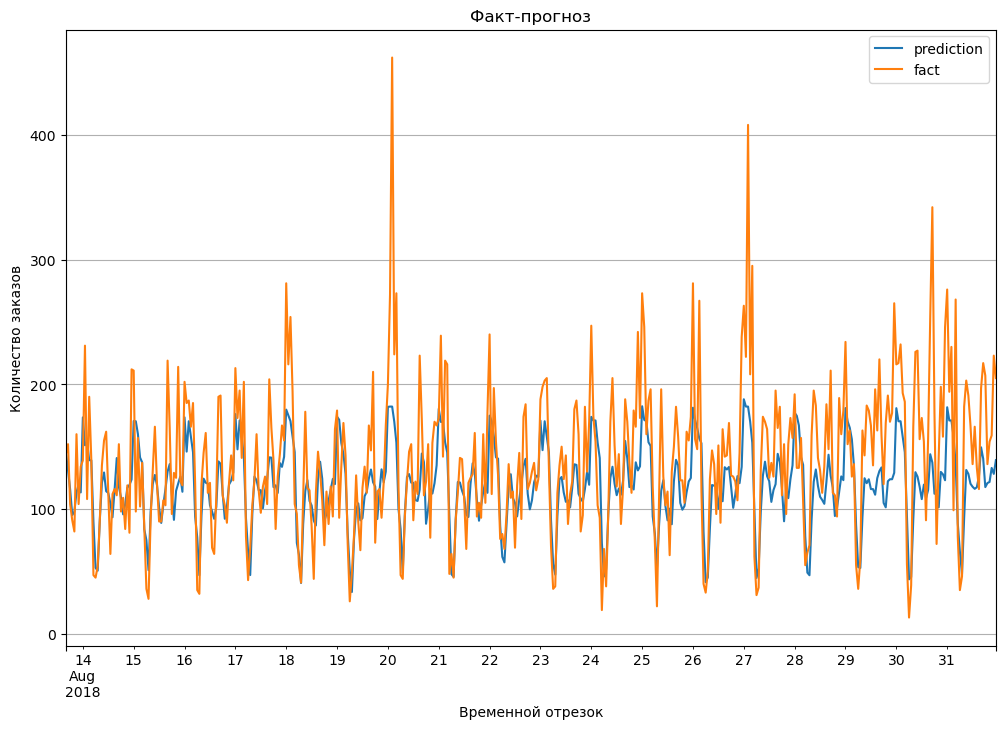

In [50]:
#изобразим график 'Факт-прогноз'
forecast_df.plot(kind='line', grid=True, xlabel='Временной отрезок', figsize=(12,8),
                 ylabel='Количество заказов', title='Факт-прогноз');

* **Как мы видим, прогноз при большом количестве заказов получается чересчур оптимистичным, а при небольшом количестве заказов почти идеально в него попадает**